In [106]:
# restart kernel after installing keras_tuner !!

!python -m pip install keras_tuner

In [207]:
import keras_tuner
import tensorflow as tf
from tensorflow import keras
import numpy as np
import datetime
import csv  
import os 

from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from src import asmsa
from src.gan import GAN
from src.visualizer import GAN_visualizer
import mdtraj as md
import nglview as nv

from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import CSVLogger, EarlyStopping
from keras.models import Sequential, Model
from keras.losses import BinaryCrossentropy, MeanSquaredError
from keras import backend as kb

In [108]:
# create session due to insufficient vram error

config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

2022-09-27 09:11:48.726498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36507 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:27:00.0, compute capability: 8.6


In [109]:
# Define input files
%cd ~

# input conformation
#conf = "alaninedipeptide_H.pdb"
conf = "trpcage_correct.pdb"

# input trajectory
# atom numbering must be consistent with {conf}

#traj = "alaninedipeptide_reduced.xtc"
traj = "trpcage_red.xtc"

# input topology
# expected to be produced with 
#    gmx pdb2gmx -f {conf} -p {topol} -n {index} 

# Gromacs changes atom numbering, the index file must be generated and used as well

#topol = "topol.top"
topol = "topol_correct.top"
index = 'index_correct.ndx'

/home/jovyan


In [110]:
tr = md.load(traj,top=conf)
idx=tr[0].top.select("name CA")
#idx=tr[0].top.select("element != H")
tr.superpose(tr[0],atom_indices=idx)
geom = np.moveaxis(tr.xyz ,0,-1)

In [111]:
# Define sparse and dense feture extensions of IC
density = 2 # integer in [1, n_atoms-1]
sparse_dists = asmsa.NBDistancesSparse(geom.shape[0], density=density)
dense_dists = asmsa.NBDistancesDense(geom.shape[0])

# mol = asmsa.Molecule(conf,topol)
# mol = asmsa.Molecule(conf,topol,fms=[sparse_dists])
mol = asmsa.Molecule(pdb=conf,top=topol,ndx=index,fms=[sparse_dists])

In [112]:
X_train = mol.intcoord(geom).T
X_train.shape

(52200, 1420)

In [113]:
molecule_shape = (X_train.shape[1],)
latent_dim = 2
prior = 'normal'

In [114]:
# encoder tuning

def build_encoder(hp_activations, params=[("selu", 32),
                                 ("selu", 16),
                                 ("selu", 8),
                                 ("linear", None)]):
    model = Sequential()
    # input layer
    model.add(Dense(params[0][1], input_dim=np.prod(molecule_shape), activation=hp_activations))
    model.add(BatchNormalization(momentum=0.8))
    # hidden layers
    model.add(Dense(params[1][1], activation=hp_activations))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(params[2][1], activation=hp_activations))
    model.add(BatchNormalization(momentum=0.8))
    #output layer
    model.add(Dense(latent_dim, activation="linear"))
    mol = Input(shape=molecule_shape)
    lowdim = model(mol)
    return Model(mol, lowdim, name="Encoder")

In [115]:
# decoder tuning

def build_decoder(hp_activations, params=[("selu", 8),
                                 ("selu", 16),
                                 ("selu", 32),
                                 ("linear", None)]):
    model = Sequential()
    model._name = "Decoder"
    # input layer
    model.add(Dense(params[0][1], input_dim=latent_dim, activation="linear"))
    model.add(BatchNormalization(momentum=0.8))
    # hidden layers
    model.add(Dense(params[1][1], activation=hp_activations))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(params[2][1], activation=hp_activations))
    model.add(BatchNormalization(momentum=0.8))
    # output layer
    model.add(Dense(np.prod(molecule_shape), activation=hp_activations))
    model.add(Reshape(molecule_shape))
    lowdim = Input(shape=(latent_dim,))
    mol = model(lowdim)
    return Model(lowdim, mol, name="Decoder")

In [116]:
# discriminator tuning

def build_discriminator(params=[(None, 512),
                                       (None, 256),
                                       (None, 256),
                                       (None, 1)]):
    model = Sequential()
    model._name = "Discriminator"
    model.add(Flatten(input_shape=(latent_dim,)))
    model.add(Dense(params[0][1]))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(params[1][1]))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(params[2][1]))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(params[3][1]))

    mol = Input(shape=(latent_dim,))
    validity = model(mol)
    return Model(mol, validity, name="Discriminator")

In [117]:
# adversarial autoencoder

class AAEModel(Model):
    def __init__(self,enc,dec,disc,latent_dim,prior):
        super().__init__()
        self.enc = enc
        self.dec = dec
        self.disc = disc
        self.lowdim = latent_dim
        self.prior = prior

In [201]:
# define hypermodel

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        
        activation_functions = hp.Choice(
            'activation', ['relu', 'gelu', 'selu'], ordered=None, default=None, parent_name=None, parent_values=None
        )
        
        enc = build_encoder(activation_functions)
        dec = build_decoder(activation_functions)
        disc = build_discriminator()
        
        return AAEModel(enc,dec,disc,latent_dim,prior)
    

    def fit(self, hp, model, X_train, callbacks=None, **kwargs):
        # Convert the datasets to tf.data.Dataset.
        
        batch_size = hp.Int("batch_size", 32, 256, step=64)
        
        # create dataset
        dataset = tf.data.Dataset.from_tensor_slices(X_train)
        dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
        
        # set loss functions
        ae_loss_fn = MeanSquaredError()
        disc_loss_fn = BinaryCrossentropy(from_logits=True)
        opt = Adam(0.0002,0.5)
        
        # The metric to track loss across training steps
        epoch_loss_metric = keras.metrics.Mean()

        # Function to run the train step.
        @tf.function
        def run_train_step(batch):
            def _get_prior(name, shape):
                if name == "normal":
                    return tf.random.normal(shape=shape)
                if name == "uniform":
                    return tf.random.uniform(shape=shape)

                raise ValueError(f"Invalid prior type '{name}'. Choose from 'normal|uniform'")

            if isinstance(batch,tuple):
                batch = batch[0]

            batch_size = tf.shape(batch)[0]

            # improve AE to reconstruct
            with tf.GradientTape(persistent=True) as ae_tape:
                reconstruct = model.dec(model.enc(batch))
                ae_loss = ae_loss_fn(batch,reconstruct)

            enc_grads = ae_tape.gradient(ae_loss, model.enc.trainable_weights)
            opt.apply_gradients(zip(enc_grads,model.enc.trainable_weights))

            dec_grads = ae_tape.gradient(ae_loss, model.dec.trainable_weights)
            opt.apply_gradients(zip(dec_grads,model.dec.trainable_weights))

            # improve discriminator
            rand_low = _get_prior(model.prior, (batch_size, model.lowdim))
            better_low = model.enc(batch)
            low = tf.concat([rand_low,better_low],axis=0)

            labels = tf.concat([tf.ones((batch_size,1)), tf.zeros((batch_size,1))], axis=0)
            labels += 0.05 * tf.random.uniform(tf.shape(labels))	# guide

            with tf.GradientTape() as disc_tape:
                pred = model.disc(low)
                disc_loss = disc_loss_fn(labels,pred)

            disc_grads = disc_tape.gradient(disc_loss,model.disc.trainable_weights)
            opt.apply_gradients(zip(disc_grads,model.disc.trainable_weights))

            # teach encoder to cheat
            alltrue = tf.ones((batch_size,1))

            with tf.GradientTape() as cheat_tape:
                cheat = model.disc(model.enc(batch))
                cheat_loss = disc_loss_fn(alltrue,cheat)

            cheat_grads = cheat_tape.gradient(cheat_loss,model.enc.trainable_weights)
            opt.apply_gradients(zip(cheat_grads,model.enc.trainable_weights))
            
            epoch_loss_metric.update_state(ae_loss)

        # Assign the model to the callbacks.
        for callback in callbacks:
            callback.model = model

        # Record the best validation loss value
        best_epoch_loss = float("inf")
        
        chosen_activation = model.enc.get_layer(index=1).get_layer(index=0).activation
        f = open(f'/home/jovyan/results/out{str(batch_size)}_{chosen_activation}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.csv', 'w')
        writer = csv.writer(f)
        # The custom training loop.
        for epoch in range(50):
            print(f"Epoch: {epoch}")

            # Iterate the training data to run the training step.
            for batch in dataset:
                run_train_step(batch)

            # Calling the callbacks after epoch.
            epoch_loss = float(epoch_loss_metric.result().numpy())
            for callback in callbacks:
                if not isinstance(callback,keras.callbacks.CSVLogger):
                    # The "my_metric" is the objective passed to the tuner.
                    callback.on_epoch_end(epoch=epoch, logs={"ae_loss": epoch_loss})
                    writer.writerow([epoch, epoch_loss])
                    
            epoch_loss_metric.reset_states()

            print(f"Autoencoder loss: {epoch_loss}")
            best_epoch_loss = min(best_epoch_loss, epoch_loss)
        f.close()
        
        # Return the evaluation metric value.
        return best_epoch_loss

In [202]:
tuner = keras_tuner.RandomSearch(
    objective=keras_tuner.Objective("ae_loss", "min"),
    max_trials=15,
    hypermodel=MyHyperModel(),
    directory="/home/jovyan/results/tb",
    project_name="custom_training",
    overwrite=True,
)

In [203]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 1
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'gelu', 'selu'], 'ordered': False}


In [204]:
tuner.search(X_train)

Trial 13 Complete [00h 00m 54s]
ae_loss: 0.021782029420137405

Best ae_loss So Far: 0.021537767723202705
Total elapsed time: 00h 29m 12s
INFO:tensorflow:Oracle triggered exit


Oracle triggered exit


In [205]:
tuner.results_summary()

Results summary
Results in /home/jovyan/results/tb/custom_training
Showing 10 best trials
Trial summary
Hyperparameters:
activation: selu
batch_size: 160
Score: 0.021537767723202705
Trial summary
Hyperparameters:
activation: selu
batch_size: 224
Score: 0.021782029420137405
Trial summary
Hyperparameters:
activation: selu
batch_size: 96
Score: 0.02207622490823269
Trial summary
Hyperparameters:
activation: selu
batch_size: 32
Score: 0.022683043032884598
Trial summary
Hyperparameters:
activation: selu
batch_size: 32
Score: 0.0227110106498003
Trial summary
Hyperparameters:
activation: gelu
batch_size: 32
Score: 0.02346639148890972
Trial summary
Hyperparameters:
activation: gelu
batch_size: 96
Score: 0.030867166817188263
Trial summary
Hyperparameters:
activation: gelu
batch_size: 224
Score: 0.030973831191658974
Trial summary
Hyperparameters:
activation: gelu
batch_size: 160
Score: 0.03108837641775608
Trial summary
Hyperparameters:
activation: relu
batch_size: 160
Score: 0.06533670425415039


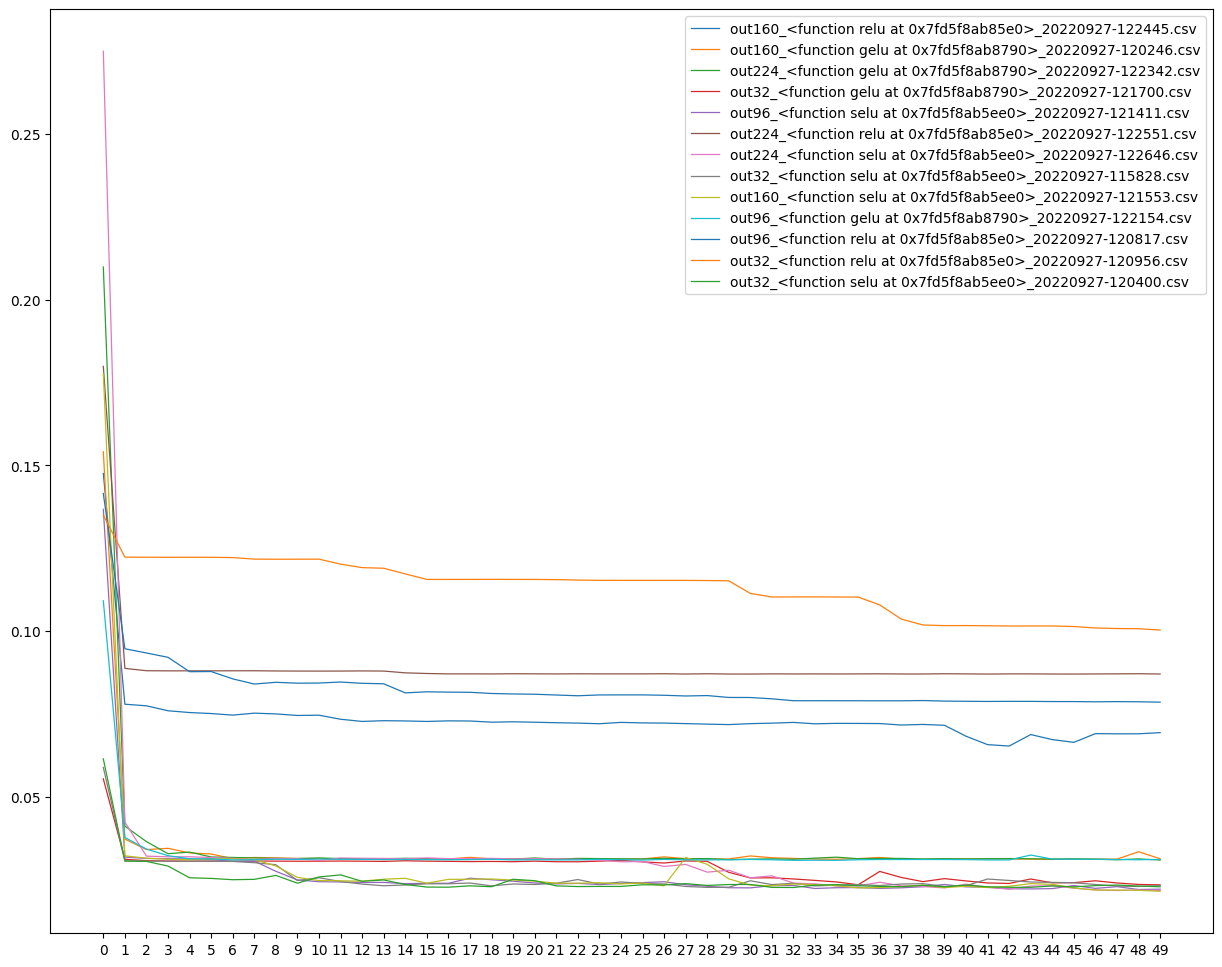

In [217]:
directory = "/home/jovyan/results"

x = []
y = []
fig, ax = plt.subplots(figsize=(15,12))  # Create a figure containing a single axes.
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        with open(f,'r') as csvfile:
            lines = csv.reader(csvfile, delimiter=',')
            for row in lines:
                x.append(row[0])
                y.append(float(row[1]))
        
        ax.plot(x, y, label=filename, linewidth=0.9)
        x = []
        y = []

ax.legend()